In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
# plt.rcParams["figure.figsize"] = (5,2)
plt.rcParams['text.usetex'] = True

# plt.rcParams.update({'font.size': 28})
matpltlib_default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# SFC, BFS, parMETIS, ptscotch respectively
method_count = 4
method_names = [r'\textrm{SFC}', r"\textsc{BFS-Part}", r'\textrm{parMETIS}', r'\textrm{PT-Scotch}']
method_colors = [matpltlib_default_colors[3], matpltlib_default_colors[2], matpltlib_default_colors[0], matpltlib_default_colors[5]] 

In [41]:
grain_sizes = [800,1200,1600]
grain_sizes_count = len(grain_sizes)
mesh_type = 'hex'
data_files = [f"results/2024-09-30__18-20-14_1rnds_test_grain_{mesh_type}_{g}.json" for g in grain_sizes]

dfs = []

for data_file in data_files:
    df = pd.read_json(data_file, orient='records',lines=True)
    # df = df[df['run_idx'] == 0] 
    # df.reset_index(drop=True, inplace=True)
    dfs.append(df)
testdf = dfs[0]

svg_i = 0

In [42]:
def plot_fixed_g_plots_violin(col_names, y_axis_label):
    assert len(col_names) == method_count

    fig0, ax0 = plt.subplots()
    fixed_g_plots = [None for _ in range(grain_sizes_count)]




    for plt_i in range(grain_sizes_count):
        vals = []
        for m_i in range(method_count):

            filtered_df = dfs[plt_i].copy()
            filtered_df.reset_index(drop=True, inplace=True)

            min_rows = filtered_df.groupby(['mesh_idx'])[col_names[m_i]].transform('min') == filtered_df[col_names[m_i]]
            min_df = filtered_df[min_rows].copy()
            min_df = min_df.drop_duplicates(subset=col_names[m_i], keep='first')
            min_df.reset_index(drop=True, inplace=True)
            
            vals.append(min_df[col_names[m_i]].copy())

        fixed_g_plots[plt_i] = ax0.violinplot(
            vals, 
            positions=[(method_count+1)*plt_i + m_i for m_i in range(method_count)], 
            showmedians=True, widths=1, points=1000, showextrema=True, bw_method=0.2)


        for i in range(method_count):
            fixed_g_plots[plt_i]['bodies'][i].set_facecolor(method_colors[i])
            fixed_g_plots[plt_i]['bodies'][i].set_alpha(0.8)

            fixed_g_plots[plt_i]['bodies'][i].set_edgecolor('black')
            fixed_g_plots[plt_i]['bodies'][i].set_linewidth(0.1)

        for partname in ('cmins', 'cmaxes', 'cmedians'):
            vp = fixed_g_plots[plt_i][partname]
            vp.set_edgecolor("black")
            vp.set_linewidth(0.7)

        fixed_g_plots[plt_i]['cbars'].set_edgecolor("black")
        fixed_g_plots[plt_i]['cbars'].set_linewidth(0)

    ax0.set_xticks([(method_count+1)*i+(method_count/2 - 0.5) for i in range(grain_sizes_count)])
    # ax0.margins(0.005)

    ax0.set_xticklabels([rf"${str(g)}$" for g in grain_sizes])

    ax0.legend([fixed_g_plots[0]["bodies"][m_i] for m_i in range(method_count)], method_names,loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)
    ax0.set_xlabel(r'\textrm{partition size (= grain size)}')
    ax0.set_ylabel(y_axis_label)
    plt.show()

In [43]:
def plot_fixed_g_plots_violin_swarm(col_names, y_axis_label, log=False):
    assert len(col_names) == method_count

    fig0, ax0 = plt.subplots()
    fixed_g_plots = [None for _ in range(method_count)]


    mesh_count = 0


    for g_i in range(grain_sizes_count):
        for m_i in range(method_count):

            filtered_df = dfs[g_i].copy()
            filtered_df.reset_index(drop=True, inplace=True)

            min_rows = filtered_df.groupby(['mesh_idx'])[col_names[m_i]].transform('min') == filtered_df[col_names[m_i]]
            min_df = filtered_df[min_rows].copy()
            min_df = min_df.drop_duplicates(subset=col_names[m_i], keep='first')
            min_df.reset_index(drop=True, inplace=True)
            data = min_df[col_names[m_i]].copy()

            mesh_count = max(mesh_count,len(data))

            position=g_i*(method_count+2)+m_i
            jitter = (np.random.rand(len(data)) - 0.5) * 0.3

            fixed_g_plots[m_i] = ax0.scatter(np.full(len(data), position + jitter), data, color=method_colors[m_i], marker='.', alpha=0.7)
            
            tmp_ = ax0.violinplot(data,positions=[position], widths=1, showmedians=True)
            for pc in tmp_['bodies']:
                pc.set_facecolor('grey')
                pc.set_edgecolor('grey')
                pc.set_alpha(0.3)
                pc.set_linewidth(0.2)
            for partname in ('cmins', 'cmaxes', 'cmedians'):
                vp = tmp_[partname]
                vp.set_edgecolor("black")
                vp.set_linewidth(0.7)
            tmp_['cbars'].set_edgecolor("black")
            tmp_['cbars'].set_linewidth(0.1)

    for g_i in range(0, grain_sizes_count -1):
        ax0.axvline(x = g_i*(method_count+2) + method_count + 0.5, color = 'grey')

    ax0.set_xticks([(method_count+2)*i+(method_count/2 - 0.5) for i in range(grain_sizes_count)])
    # ax0.margins(0.005)
    if log:
        ax0.set_yscale('log')

    ax0.set_xticklabels([rf"${str(g)}$" for g in grain_sizes])

    ax0.legend([fixed_g_plots[m_i] for m_i in range(method_count)], method_names,loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
    ax0.set_xlabel(r'\textrm{partition size (= grain size)}')
    ax0.set_ylabel(y_axis_label)
    ax0.set_title(f"{mesh_count} {mesh_type} meshes\n\n"+y_axis_label, pad=32)

    plt.show()
    global svg_i
    fig0.savefig(f'plot_{svg_i}.svg', format='svg', pad_inches=0, bbox_inches='tight')
    svg_i+=1

In [44]:
def plot_fixed_g_plots_box(col_names, y_axis_label):
    assert len(col_names) == method_count

    fig0, ax0 = plt.subplots()
    fixed_g_plots = [None for _ in range(grain_sizes_count)]




    for plt_i in range(grain_sizes_count):
        vals = []
        for m_i in range(method_count):

            filtered_df = dfs[plt_i].copy()
            filtered_df.reset_index(drop=True, inplace=True)

            min_rows = filtered_df.groupby(['mesh_idx'])[col_names[m_i]].transform('min') == filtered_df[col_names[m_i]]
            min_df = filtered_df[min_rows].copy()
            min_df = min_df.drop_duplicates(subset=col_names[m_i], keep='first')
            min_df.reset_index(drop=True, inplace=True)
            
            vals.append(min_df[col_names[m_i]].copy())

        fixed_g_plots[plt_i] = ax0.boxplot(
            vals, 
            positions=[(method_count+1)*plt_i + m_i for m_i in range(method_count)], 
            widths=0.8, patch_artist=True)


        for i in range(method_count):
            fixed_g_plots[plt_i]['boxes'][i].set_facecolor(method_colors[i])
            fixed_g_plots[plt_i]['boxes'][i].set_alpha(0.8)

        #     fixed_g_plots[plt_i]['bodies'][i].set_edgecolor('black')
        #     fixed_g_plots[plt_i]['bodies'][i].set_linewidth(0.1)

        # for partname in ('cmins', 'cmaxes', 'cmedians'):
        #     vp = fixed_g_plots[plt_i][partname]
        #     vp.set_edgecolor("black")
        #     vp.set_linewidth(0.7)

        # fixed_g_plots[plt_i]['cbars'].set_edgecolor("black")
        # fixed_g_plots[plt_i]['cbars'].set_linewidth(0)

    ax0.set_xticks([(method_count+1)*i+(method_count/2 - 0.5) for i in range(grain_sizes_count)])
    # ax0.margins(0.005)

    ax0.set_xticklabels([rf"${str(g)}$" for g in grain_sizes])

    ax0.legend([fixed_g_plots[0]["boxes"][m_i] for m_i in range(method_count)], method_names,loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)
    ax0.set_xlabel(r'\textrm{partition size (= grain size)}')
    ax0.set_ylabel(y_axis_label)
    plt.show()

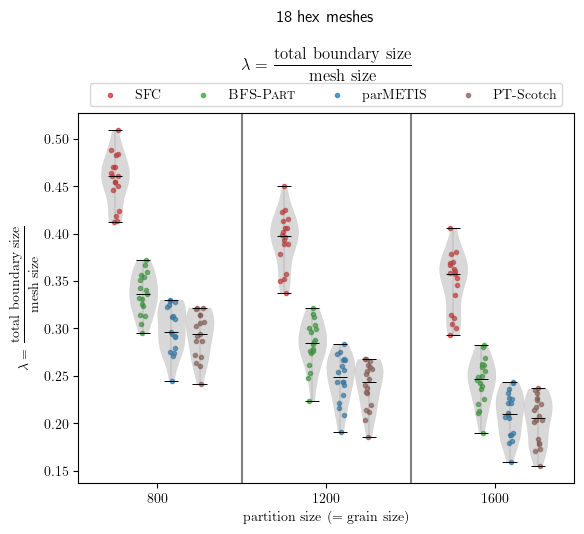

In [45]:
# plotting boundary ratio

col_names = ['SFC_morton_boundary_ratio','BFS_boundary_ratio','parMETIS_boundary_ratio','ptscotch_boundary_ratio']

plot_fixed_g_plots_violin_swarm(col_names, r'\[\lambda = \frac{\textrm{total boundary size}}{\textrm{mesh size}}\]')



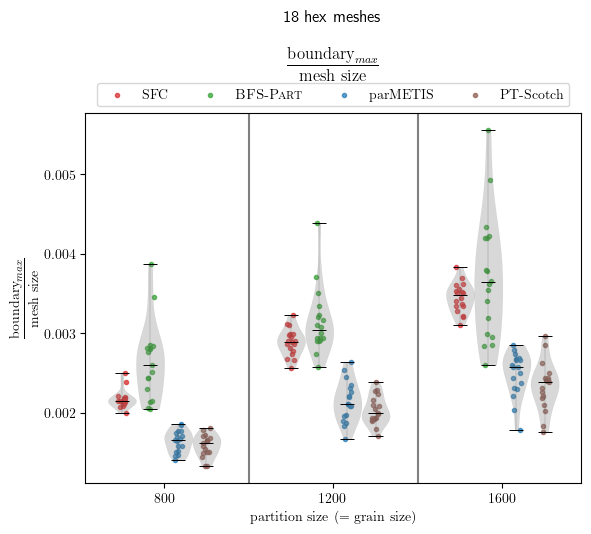

In [46]:
temp_cols = ['SFC_morton_partition_boundaries','BFS_partition_boundaries','parMETIS_partition_boundaries','ptscotch_partition_boundaries']
max_cols = [col+'_max' for col in temp_cols]

for g_i in range(len(grain_sizes)):
    for col_i in range(len(temp_cols)):
        dfs[g_i][max_cols[col_i]] = dfs[g_i][temp_cols[col_i]].apply(lambda x: max(x)) / dfs[g_i]['n']

plot_fixed_g_plots_violin_swarm(max_cols, r'\[\frac{\textrm{boundary}_{max}}{\textrm{mesh size}}\]')




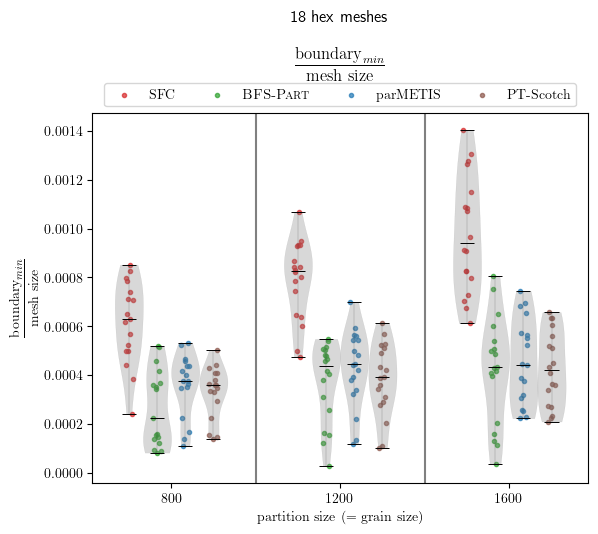

In [47]:
temp_cols = ['SFC_morton_partition_boundaries','BFS_partition_boundaries','parMETIS_partition_boundaries','ptscotch_partition_boundaries']
min_cols = [col+'_min' for col in temp_cols]

for g_i in range(len(grain_sizes)):
    for col_i in range(len(temp_cols)):
        dfs[g_i][min_cols[col_i]] = dfs[g_i][temp_cols[col_i]].apply(lambda x: min(x)) / dfs[g_i]['n']

plot_fixed_g_plots_violin_swarm(min_cols, r'\[\frac{\textrm{boundary}_{min}}{\textrm{mesh size}}\]')

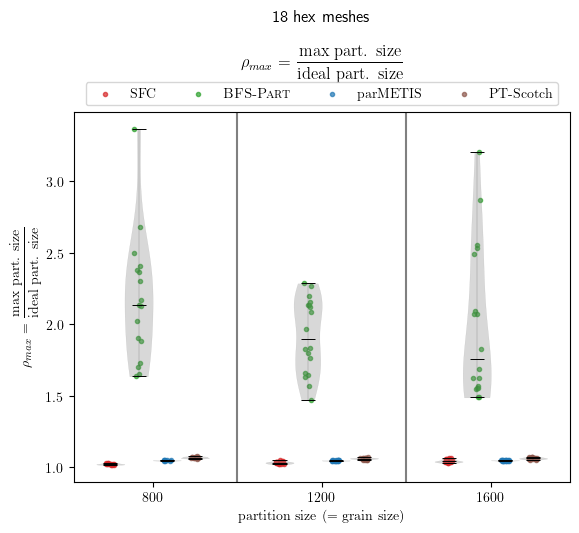

In [48]:
# plotting max partition size

col_names = ['SFC_morton_rho_max','BFS_rho_max','parMETIS_rho_max','ptscotch_rho_max']

plot_fixed_g_plots_violin_swarm(col_names, r'\[\rho_{max}=\frac{\textrm{max part. size}}{\textrm{ideal part. size}}\]')

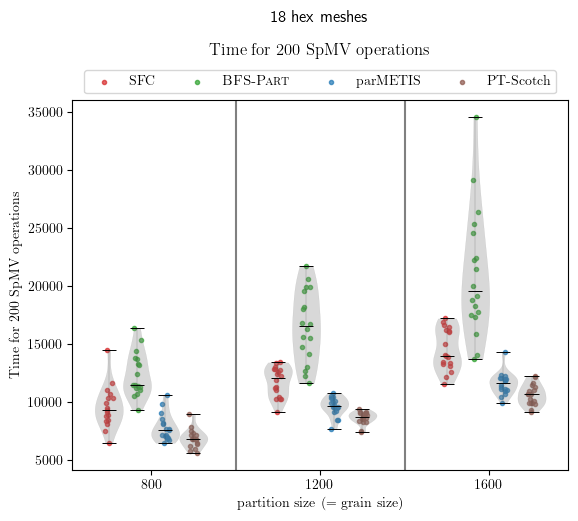

In [49]:
col_names = ['SFC_morton_matvec_time','BFS_matvec_time','parMETIS_matvec_time','ptscotch_matvec_time']

plot_fixed_g_plots_violin_swarm(col_names, r'\textrm{Time for 200 SpMV operations}')

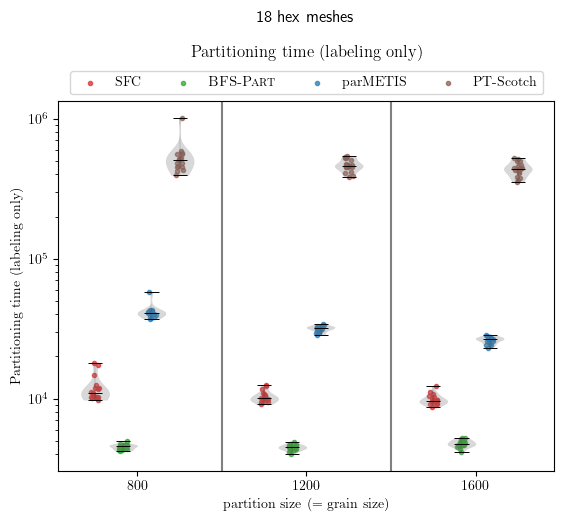

In [50]:
col_names = ['SFC_morton_partition_time','BFS_labeling_time','parMETIS_labeling_time','ptscotch_labeling_time']

plot_fixed_g_plots_violin_swarm(col_names, r'\textrm{Partitioning time (labeling only)}', log=True)

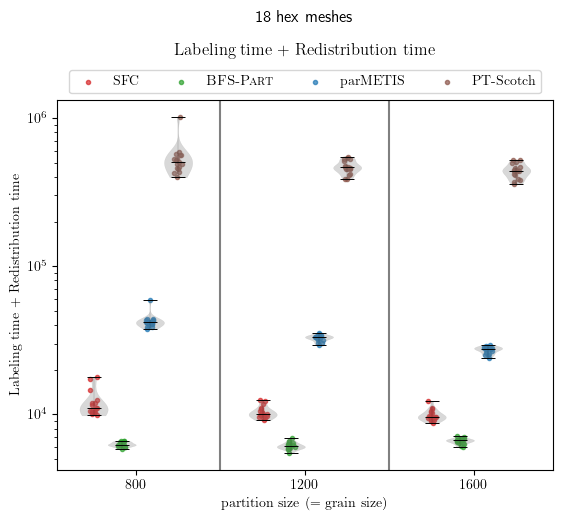

In [51]:
for g_i in range(len(grain_sizes)):
    dfs[g_i]['BFS_label_and_redistribution_time'] = dfs[g_i]['BFS_labeling_time'] + dfs[g_i]['BFS_redistribution_time']
    dfs[g_i]['parMETIS_label_and_redistribution_time'] = dfs[g_i]['parMETIS_labeling_time'] + dfs[g_i]['parMETIS_redistribution_time']
    dfs[g_i]['ptscotch_label_and_redistribution_time'] = dfs[g_i]['ptscotch_labeling_time'] + dfs[g_i]['ptscotch_redistribution_time']


col_names = ['SFC_morton_partition_time','BFS_label_and_redistribution_time','parMETIS_label_and_redistribution_time','ptscotch_label_and_redistribution_time']

plot_fixed_g_plots_violin_swarm(col_names, r'\textrm{Labeling time + Redistribution time}', log=True)

In [52]:
# col_names = ['SFC_morton_boundary_ratio','BFS_boundary_ratio','parMETIS_boundary_ratio','ptscotch_boundary_ratio']

# fig0, ax0 = plt.subplots()
# fixed_g_plots = [None for _ in range(method_count)]
# # dt = [list(dfs[plt_i][col]) for plt_i in range(grain_sizes_count)  for col in col_names ]
# # print(dt)
# # sns.swarmplot(data=dt[0], ax=ax0, color=method_colors[0])
# # sns.swarmplot(data=dt, ax=ax0, color=method_colors)

# for g_i in range(grain_sizes_count):
#     for m_i in range(method_count):
#         data_ = dfs[g_i][col_names[m_i]]
#         position=g_i*(method_count+1)+m_i

#         jitter = (np.random.rand(len(data_)) - 0.5) * 0.2

#         fixed_g_plots[m_i] = ax0.scatter(np.full(len(data_), position + jitter), data_, color=method_colors[m_i], marker='.', alpha=0.5)

#         # ax0.boxplot(data_,positions=[position - 0.2])
        
#         tmp_ = ax0.violinplot(data_,positions=[position], widths=0.75, showmedians=True)
#         for pc in tmp_['bodies']:
#             pc.set_facecolor('grey')
#             pc.set_edgecolor('grey')
#             pc.set_alpha(0.3)
#             pc.set_linewidth(0.2)
#         for partname in ('cmins', 'cmaxes', 'cmedians'):
#             vp = tmp_[partname]
#             vp.set_edgecolor("black")
#             vp.set_linewidth(0.7)
#         tmp_['cbars'].set_edgecolor("black")
#         tmp_['cbars'].set_linewidth(0.1)


# ax0.set_xticks([(method_count+1)*i+(method_count/2 - 0.5) for i in range(grain_sizes_count)])
# # ax0.margins(0.005)

# ax0.set_xticklabels([rf"${str(g)}$" for g in grain_sizes])

# ax0.legend([fixed_g_plots[m_i] for m_i in range(method_count)], method_names,loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)
# ax0.set_xlabel(r'\textrm{grain size}')
# ax0.set_ylabel(r'$\lambda$')


# fig0.savefig('lambda.pdf', format='pdf', pad_inches=0, bbox_inches='tight')
